In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.set_random_seed(1)
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
batch_size = 64
cifar10 = CIFAR10(batch_size=batch_size, validation_proportion=0.1, augment_data=False, file='nuevos datos/data_original.csv')

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name, stride = 1):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer(uniform=False))
    biases = tf.get_variable("biases", [kernel_shape[2]],
                             initializer=tf.constant_initializer(0.05))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv1d(input_tensor, weights, 
                       stride = stride, padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)


In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input', 
                             shape=(None,200,1))

keep_prob = tf.placeholder(tf.float32, name='dropout_prob', shape=())

target = tf.placeholder(tf.float32, name='target', shape=(None, 9))

# First convolution layer
layer_name = 'conv1'
with tf.variable_scope(layer_name):
    conv1_out = conv_layer(model_input, [9, 1, 20], layer_name, 2)
# First pooling layer
with tf.name_scope('pool1'):
    pool1_out = tf.nn.pool(conv1_out, window_shape=[2],
                pooling_type="AVG", padding='SAME', strides=[2],
                name='pool1')
    

# Second convolution layer
layer_name = 'conv2'
with tf.variable_scope(layer_name):
    conv2_out = conv_layer(pool1_out, [5, 20, 20], layer_name)
# Second pooling layer
with tf.name_scope('pool2'):
    pool2_out = tf.nn.pool(conv2_out, window_shape=[2],
                pooling_type="AVG", padding='SAME', strides=[2],
                name='pool2')

In [6]:
_,dim3,dim4 = pool2_out.shape
print(dim3,dim4)

25 20


In [7]:
pool2_out_flat = tf.reshape(pool2_out, [-1, 1*dim3.value*dim4.value], name='pool2_flat')
# First fully connected layer
layer_name = 'fc4'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(pool2_out_flat, [1*dim3.value*dim4.value, 250], layer_name)
fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

# Second fully connected layer
layer_name = 'fc5'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [250, 100], layer_name)
fc2_out_drop = tf.nn.dropout(fc2_out, keep_prob)


# Third fully connected layer
layer_name = 'fc6'
with tf.variable_scope(layer_name):
    fc3_out = fc_layer(fc2_out_drop, [100,9], layer_name)
model_output = fc3_out


with tf.name_scope('loss_function2'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model_output, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [8]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(model_output, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run(merged,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [9]:
# Train model
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/trainavg',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validationavg')
sess.run(tf.global_variables_initializer())
cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)

epochs = 1200
mean_gradients = np.zeros([len(tf.trainable_variables()), epochs])
std_gradients = np.zeros([len(tf.trainable_variables()), epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run(train_step,
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run(merged,
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 0.5 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer, epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer, epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
train_writer.flush()
validation_writer.flush()
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
fc4/weights:0
fc4/biases:0
fc5/weights:0
fc5/biases:0
fc6/weights:0
fc6/biases:0
Epoch 0, training loss 2.163573, accuracy 0.125000
Validation accuracy 0.105625
Time elapsed 0.003136161963144938 minutes
Epoch 1, training loss 2.193006, accuracy 0.125000
Validation accuracy 0.130625
Time elapsed 0.05136767625808716 minutes
Epoch 2, training loss 2.209007, accuracy 0.109375
Validation accuracy 0.204375
Time elapsed 0.10052382946014404 minutes
Epoch 3, training loss 1.800329, accuracy 0.328125
Validation accuracy 0.240000
Time elapsed 0.1483332633972168 minutes
Epoch 4, training loss 1.970694, accuracy 0.125000
Validation accuracy 0.214375
Time elapsed 0.19677267471949259 minutes
Epoch 5, training loss 1.962253, accuracy 0.250000
Validation accuracy 0.245625
Time elapsed 0.2468438506126404 minutes
Epoch 6, training loss 1.753705, accuracy 0.328125
Validation accuracy 0.244375
Time elapsed 0.2982256730397542 

Epoch 67, training loss 1.482645, accuracy 0.390625
Validation accuracy 0.410000
Time elapsed 3.4266160249710085 minutes
Epoch 68, training loss 1.590218, accuracy 0.453125
Validation accuracy 0.398750
Time elapsed 3.4747312307357787 minutes
Epoch 69, training loss 1.470262, accuracy 0.531250
Validation accuracy 0.424375
Time elapsed 3.523601428667704 minutes
Epoch 70, training loss 1.475092, accuracy 0.421875
Validation accuracy 0.405000
Time elapsed 3.5715392430623374 minutes
Epoch 71, training loss 1.369152, accuracy 0.500000
Validation accuracy 0.416875
Time elapsed 3.618962093194326 minutes
Epoch 72, training loss 1.496183, accuracy 0.406250
Validation accuracy 0.416875
Time elapsed 3.666789964834849 minutes
Epoch 73, training loss 1.544053, accuracy 0.343750
Validation accuracy 0.437500
Time elapsed 3.714872578779856 minutes
Epoch 74, training loss 1.313029, accuracy 0.484375
Validation accuracy 0.433125
Time elapsed 3.7773006598154706 minutes
Epoch 75, training loss 1.449724, ac

Epoch 135, training loss 1.190786, accuracy 0.500000
Validation accuracy 0.505000
Time elapsed 6.830052717526754 minutes
Epoch 136, training loss 1.160020, accuracy 0.609375
Validation accuracy 0.509375
Time elapsed 6.878133324782054 minutes
Epoch 137, training loss 1.356938, accuracy 0.500000
Validation accuracy 0.525625
Time elapsed 6.924911379814148 minutes
Epoch 138, training loss 1.110186, accuracy 0.546875
Validation accuracy 0.530000
Time elapsed 6.975099297364553 minutes
Epoch 139, training loss 1.205903, accuracy 0.562500
Validation accuracy 0.543125
Time elapsed 7.037625932693482 minutes
Epoch 140, training loss 1.156496, accuracy 0.515625
Validation accuracy 0.517500
Time elapsed 7.085672775904338 minutes
Epoch 141, training loss 1.119040, accuracy 0.562500
Validation accuracy 0.522500
Time elapsed 7.131685733795166 minutes
Epoch 142, training loss 1.143903, accuracy 0.546875
Validation accuracy 0.549375
Time elapsed 7.178751448790233 minutes
Epoch 143, training loss 1.12413

Epoch 203, training loss 0.926949, accuracy 0.609375
Validation accuracy 0.575625
Time elapsed 10.455042552947997 minutes
Epoch 204, training loss 1.234093, accuracy 0.562500
Validation accuracy 0.583125
Time elapsed 10.50341855287552 minutes
Epoch 205, training loss 0.932105, accuracy 0.625000
Validation accuracy 0.574375
Time elapsed 10.557698512077332 minutes
Epoch 206, training loss 1.102970, accuracy 0.578125
Validation accuracy 0.552500
Time elapsed 10.607605000336966 minutes
Epoch 207, training loss 0.989173, accuracy 0.671875
Validation accuracy 0.570625
Time elapsed 10.65785375436147 minutes
Epoch 208, training loss 1.036163, accuracy 0.515625
Validation accuracy 0.560000
Time elapsed 10.708656851450602 minutes
Epoch 209, training loss 1.109834, accuracy 0.546875
Validation accuracy 0.571875
Time elapsed 10.761899463335673 minutes
Epoch 210, training loss 1.196851, accuracy 0.593750
Validation accuracy 0.545000
Time elapsed 10.8145352602005 minutes
Epoch 211, training loss 0.9

Epoch 271, training loss 1.056695, accuracy 0.593750
Validation accuracy 0.616250
Time elapsed 14.203775143623352 minutes
Epoch 272, training loss 0.992708, accuracy 0.609375
Validation accuracy 0.584375
Time elapsed 14.25672442515691 minutes
Epoch 273, training loss 0.983063, accuracy 0.562500
Validation accuracy 0.622500
Time elapsed 14.31920827627182 minutes
Epoch 274, training loss 0.983964, accuracy 0.609375
Validation accuracy 0.550625
Time elapsed 14.381986848513286 minutes
Epoch 275, training loss 0.995548, accuracy 0.687500
Validation accuracy 0.606250
Time elapsed 14.442736911773682 minutes
Epoch 276, training loss 0.862024, accuracy 0.609375
Validation accuracy 0.582500
Time elapsed 14.503069933255514 minutes
Epoch 277, training loss 1.020599, accuracy 0.562500
Validation accuracy 0.621875
Time elapsed 14.567220532894135 minutes
Epoch 278, training loss 0.887498, accuracy 0.578125
Validation accuracy 0.603750
Time elapsed 14.617402803897857 minutes
Epoch 279, training loss 0

Epoch 339, training loss 0.745988, accuracy 0.718750
Validation accuracy 0.632500
Time elapsed 18.09318525791168 minutes
Epoch 340, training loss 0.935197, accuracy 0.593750
Validation accuracy 0.637500
Time elapsed 18.141976896921793 minutes
Epoch 341, training loss 0.846278, accuracy 0.593750
Validation accuracy 0.635000
Time elapsed 18.198701639970142 minutes
Epoch 342, training loss 0.799608, accuracy 0.625000
Validation accuracy 0.616875
Time elapsed 18.25351518789927 minutes
Epoch 343, training loss 0.719888, accuracy 0.734375
Validation accuracy 0.638750
Time elapsed 18.30449048280716 minutes
Epoch 344, training loss 0.934957, accuracy 0.625000
Validation accuracy 0.630000
Time elapsed 18.354623838265738 minutes
Epoch 345, training loss 1.031954, accuracy 0.609375
Validation accuracy 0.628125
Time elapsed 18.408923749128977 minutes
Epoch 346, training loss 0.806837, accuracy 0.703125
Validation accuracy 0.632500
Time elapsed 18.45951669216156 minutes
Epoch 347, training loss 0.9

Epoch 407, training loss 0.855085, accuracy 0.593750
Validation accuracy 0.649375
Time elapsed 21.90049944718679 minutes
Epoch 408, training loss 0.952187, accuracy 0.562500
Validation accuracy 0.626875
Time elapsed 21.961540746688843 minutes
Epoch 409, training loss 0.721645, accuracy 0.734375
Validation accuracy 0.659375
Time elapsed 22.021293413639068 minutes
Epoch 410, training loss 0.995564, accuracy 0.609375
Validation accuracy 0.668750
Time elapsed 22.07165983915329 minutes
Epoch 411, training loss 0.804847, accuracy 0.656250
Validation accuracy 0.648125
Time elapsed 22.127757080396016 minutes
Epoch 412, training loss 0.823689, accuracy 0.656250
Validation accuracy 0.631875
Time elapsed 22.18545301357905 minutes
Epoch 413, training loss 0.992314, accuracy 0.609375
Validation accuracy 0.646250
Time elapsed 22.245269310474395 minutes
Epoch 414, training loss 0.883089, accuracy 0.765625
Validation accuracy 0.643750
Time elapsed 22.329658246040346 minutes
Epoch 415, training loss 0.

Epoch 475, training loss 0.683178, accuracy 0.734375
Validation accuracy 0.672500
Time elapsed 26.002435624599457 minutes
Epoch 476, training loss 0.866228, accuracy 0.718750
Validation accuracy 0.660625
Time elapsed 26.059333451588948 minutes
Epoch 477, training loss 0.906954, accuracy 0.718750
Validation accuracy 0.670625
Time elapsed 26.112408383687338 minutes
Epoch 478, training loss 0.783393, accuracy 0.703125
Validation accuracy 0.663125
Time elapsed 26.162314275900524 minutes
Epoch 479, training loss 0.744802, accuracy 0.734375
Validation accuracy 0.669375
Time elapsed 26.222282107671102 minutes
Epoch 480, training loss 0.760721, accuracy 0.656250
Validation accuracy 0.668125
Time elapsed 26.28244094848633 minutes
Epoch 481, training loss 0.828196, accuracy 0.687500
Validation accuracy 0.682500
Time elapsed 26.336568252245584 minutes
Epoch 482, training loss 0.595849, accuracy 0.812500
Validation accuracy 0.673125
Time elapsed 26.390404323736828 minutes
Epoch 483, training loss 

Epoch 543, training loss 0.867582, accuracy 0.656250
Validation accuracy 0.680000
Time elapsed 29.93155250946681 minutes
Epoch 544, training loss 0.695927, accuracy 0.671875
Validation accuracy 0.678125
Time elapsed 29.98376186688741 minutes
Epoch 545, training loss 0.862232, accuracy 0.703125
Validation accuracy 0.672500
Time elapsed 30.037547155221304 minutes
Epoch 546, training loss 0.788819, accuracy 0.671875
Validation accuracy 0.658750
Time elapsed 30.088427658875784 minutes
Epoch 547, training loss 0.721893, accuracy 0.718750
Validation accuracy 0.685000
Time elapsed 30.14156850973765 minutes
Epoch 548, training loss 0.728768, accuracy 0.781250
Validation accuracy 0.690000
Time elapsed 30.197388442357383 minutes
Epoch 549, training loss 0.770179, accuracy 0.625000
Validation accuracy 0.682500
Time elapsed 30.283301723003387 minutes
Epoch 550, training loss 0.774109, accuracy 0.640625
Validation accuracy 0.696875
Time elapsed 30.341587058703105 minutes
Epoch 551, training loss 0.

Epoch 611, training loss 0.711975, accuracy 0.734375
Validation accuracy 0.681875
Time elapsed 33.56162070830663 minutes
Epoch 612, training loss 0.975111, accuracy 0.562500
Validation accuracy 0.656875
Time elapsed 33.60995822747548 minutes
Epoch 613, training loss 0.736041, accuracy 0.734375
Validation accuracy 0.693125
Time elapsed 33.66030346155166 minutes
Epoch 614, training loss 0.804692, accuracy 0.640625
Validation accuracy 0.703750
Time elapsed 33.70711307922999 minutes
Epoch 615, training loss 0.771921, accuracy 0.656250
Validation accuracy 0.692500
Time elapsed 33.75792870124181 minutes
Epoch 616, training loss 0.755796, accuracy 0.703125
Validation accuracy 0.701250
Time elapsed 33.8061842083931 minutes
Epoch 617, training loss 0.699781, accuracy 0.609375
Validation accuracy 0.699375
Time elapsed 33.852846173445386 minutes
Epoch 618, training loss 0.703670, accuracy 0.765625
Validation accuracy 0.698125
Time elapsed 33.90038062731425 minutes
Epoch 619, training loss 0.73511

Epoch 679, training loss 0.670341, accuracy 0.734375
Validation accuracy 0.701250
Time elapsed 36.80479905207952 minutes
Epoch 680, training loss 0.610176, accuracy 0.796875
Validation accuracy 0.710000
Time elapsed 36.85266970793406 minutes
Epoch 681, training loss 0.652202, accuracy 0.671875
Validation accuracy 0.711250
Time elapsed 36.89922496477763 minutes
Epoch 682, training loss 0.603230, accuracy 0.781250
Validation accuracy 0.707500
Time elapsed 36.94648036162059 minutes
Epoch 683, training loss 0.662742, accuracy 0.765625
Validation accuracy 0.716875
Time elapsed 36.99376448392868 minutes
Epoch 684, training loss 0.891559, accuracy 0.640625
Validation accuracy 0.666875
Time elapsed 37.03992698987325 minutes
Epoch 685, training loss 0.725770, accuracy 0.671875
Validation accuracy 0.708750
Time elapsed 37.08689699172974 minutes
Epoch 686, training loss 0.618073, accuracy 0.765625
Validation accuracy 0.693125
Time elapsed 37.13307704528173 minutes
Epoch 687, training loss 0.61124

Epoch 747, training loss 0.667415, accuracy 0.750000
Validation accuracy 0.713750
Time elapsed 40.02826677163442 minutes
Epoch 748, training loss 0.757923, accuracy 0.765625
Validation accuracy 0.701250
Time elapsed 40.073974430561066 minutes
Epoch 749, training loss 0.641718, accuracy 0.828125
Validation accuracy 0.722500
Time elapsed 40.12069488366445 minutes
Epoch 750, training loss 0.551703, accuracy 0.812500
Validation accuracy 0.701875
Time elapsed 40.166665530204774 minutes
Epoch 751, training loss 0.627431, accuracy 0.781250
Validation accuracy 0.707500
Time elapsed 40.2122320095698 minutes
Epoch 752, training loss 0.776025, accuracy 0.703125
Validation accuracy 0.705625
Time elapsed 40.26011239290237 minutes
Epoch 753, training loss 0.695870, accuracy 0.750000
Validation accuracy 0.681875
Time elapsed 40.308546427885695 minutes
Epoch 754, training loss 0.635227, accuracy 0.765625
Validation accuracy 0.705625
Time elapsed 40.356114184856416 minutes
Epoch 755, training loss 0.49

Epoch 815, training loss 0.560720, accuracy 0.812500
Validation accuracy 0.698750
Time elapsed 43.20611929496129 minutes
Epoch 816, training loss 0.742854, accuracy 0.734375
Validation accuracy 0.726875
Time elapsed 43.25330879290899 minutes
Epoch 817, training loss 0.670581, accuracy 0.765625
Validation accuracy 0.724375
Time elapsed 43.30190382003784 minutes
Epoch 818, training loss 0.743066, accuracy 0.687500
Validation accuracy 0.723125
Time elapsed 43.35009088516235 minutes
Epoch 819, training loss 0.628918, accuracy 0.765625
Validation accuracy 0.711250
Time elapsed 43.39814472993215 minutes
Epoch 820, training loss 0.535511, accuracy 0.765625
Validation accuracy 0.720000
Time elapsed 43.44629987080892 minutes
Epoch 821, training loss 0.671701, accuracy 0.718750
Validation accuracy 0.723125
Time elapsed 43.49390401045481 minutes
Epoch 822, training loss 0.770372, accuracy 0.671875
Validation accuracy 0.708125
Time elapsed 43.540480415026344 minutes
Epoch 823, training loss 0.7342

Epoch 883, training loss 0.656313, accuracy 0.812500
Validation accuracy 0.713750
Time elapsed 46.394785249233244 minutes
Epoch 884, training loss 0.787476, accuracy 0.703125
Validation accuracy 0.699375
Time elapsed 46.439908945560454 minutes
Epoch 885, training loss 0.645841, accuracy 0.734375
Validation accuracy 0.728125
Time elapsed 46.48563311100006 minutes
Epoch 886, training loss 0.483200, accuracy 0.843750
Validation accuracy 0.715000
Time elapsed 46.53124189376831 minutes
Epoch 887, training loss 0.701462, accuracy 0.718750
Validation accuracy 0.722500
Time elapsed 46.57672468026479 minutes
Epoch 888, training loss 0.570660, accuracy 0.781250
Validation accuracy 0.718125
Time elapsed 46.62213574250539 minutes
Epoch 889, training loss 0.681374, accuracy 0.718750
Validation accuracy 0.683125
Time elapsed 46.66864809195201 minutes
Epoch 890, training loss 0.609302, accuracy 0.734375
Validation accuracy 0.718750
Time elapsed 46.71377510627111 minutes
Epoch 891, training loss 0.561

Epoch 951, training loss 0.609914, accuracy 0.750000
Validation accuracy 0.725625
Time elapsed 49.58142872254054 minutes
Epoch 952, training loss 0.527659, accuracy 0.781250
Validation accuracy 0.711875
Time elapsed 49.62806344827016 minutes
Epoch 953, training loss 0.677348, accuracy 0.656250
Validation accuracy 0.719375
Time elapsed 49.67442629337311 minutes
Epoch 954, training loss 0.542657, accuracy 0.781250
Validation accuracy 0.715625
Time elapsed 49.72151700258255 minutes
Epoch 955, training loss 0.448588, accuracy 0.843750
Validation accuracy 0.736250
Time elapsed 49.771868443489076 minutes
Epoch 956, training loss 0.556873, accuracy 0.750000
Validation accuracy 0.737500
Time elapsed 49.81819576819738 minutes
Epoch 957, training loss 0.723238, accuracy 0.687500
Validation accuracy 0.731875
Time elapsed 49.8642834464709 minutes
Epoch 958, training loss 0.625340, accuracy 0.750000
Validation accuracy 0.728125
Time elapsed 49.91022979815801 minutes
Epoch 959, training loss 0.74418

Epoch 1019, training loss 0.648789, accuracy 0.796875
Validation accuracy 0.731250
Time elapsed 52.79625564813614 minutes
Epoch 1020, training loss 0.518787, accuracy 0.812500
Validation accuracy 0.722500
Time elapsed 52.84577154318492 minutes
Epoch 1021, training loss 0.565316, accuracy 0.843750
Validation accuracy 0.741250
Time elapsed 52.89204237858454 minutes
Epoch 1022, training loss 0.579956, accuracy 0.796875
Validation accuracy 0.740000
Time elapsed 52.93757217725118 minutes
Epoch 1023, training loss 0.668480, accuracy 0.765625
Validation accuracy 0.731250
Time elapsed 52.98320455948512 minutes
Epoch 1024, training loss 0.599689, accuracy 0.796875
Validation accuracy 0.743750
Time elapsed 53.0291801015536 minutes
Epoch 1025, training loss 0.516010, accuracy 0.796875
Validation accuracy 0.736875
Time elapsed 53.074773033459984 minutes
Epoch 1026, training loss 0.557350, accuracy 0.781250
Validation accuracy 0.728125
Time elapsed 53.120453266302746 minutes
Epoch 1027, training lo

Epoch 1087, training loss 0.549541, accuracy 0.828125
Validation accuracy 0.736250
Time elapsed 55.98045199314753 minutes
Epoch 1088, training loss 0.498574, accuracy 0.765625
Validation accuracy 0.735625
Time elapsed 56.02771120071411 minutes
Epoch 1089, training loss 0.665575, accuracy 0.656250
Validation accuracy 0.728750
Time elapsed 56.07417155901591 minutes
Epoch 1090, training loss 0.560627, accuracy 0.765625
Validation accuracy 0.738750
Time elapsed 56.12079197565715 minutes
Epoch 1091, training loss 0.540984, accuracy 0.750000
Validation accuracy 0.750000
Time elapsed 56.16790012915929 minutes
Epoch 1092, training loss 0.533061, accuracy 0.812500
Validation accuracy 0.751250
Time elapsed 56.21404832998912 minutes
Epoch 1093, training loss 0.547072, accuracy 0.859375
Validation accuracy 0.743750
Time elapsed 56.26352095603943 minutes
Epoch 1094, training loss 0.579821, accuracy 0.781250
Validation accuracy 0.731250
Time elapsed 56.31071089506149 minutes
Epoch 1095, training los

Epoch 1155, training loss 0.500768, accuracy 0.796875
Validation accuracy 0.733125
Time elapsed 59.19558339913686 minutes
Epoch 1156, training loss 0.692722, accuracy 0.687500
Validation accuracy 0.746250
Time elapsed 59.243299583594 minutes
Epoch 1157, training loss 0.506060, accuracy 0.812500
Validation accuracy 0.746250
Time elapsed 59.29146012067795 minutes
Epoch 1158, training loss 0.644124, accuracy 0.687500
Validation accuracy 0.735000
Time elapsed 59.341771976153055 minutes
Epoch 1159, training loss 0.589738, accuracy 0.703125
Validation accuracy 0.738750
Time elapsed 59.38758415778478 minutes
Epoch 1160, training loss 0.558446, accuracy 0.781250
Validation accuracy 0.735625
Time elapsed 59.434611864884694 minutes
Epoch 1161, training loss 0.669849, accuracy 0.765625
Validation accuracy 0.745625
Time elapsed 59.48131911357244 minutes
Epoch 1162, training loss 0.662259, accuracy 0.718750
Validation accuracy 0.745000
Time elapsed 59.52807288567225 minutes
Epoch 1163, training los

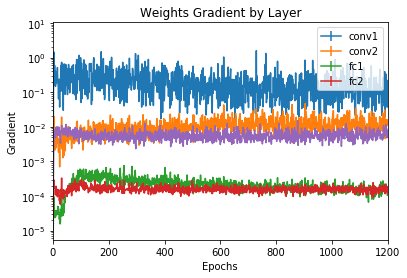

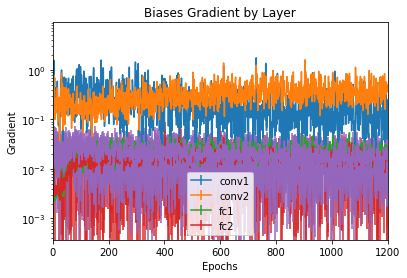

In [10]:
# Plotting gradients
n_layers = len(tf.trainable_variables()) // 2
x = np.arange(epochs)
i = 0
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()

In [11]:
def confusion_matrix(targets, outputs):
    '''Returns a confusion matrix. Both targets and outputs
    should be 1-D arrays of zeros and ones.'''
    encoded_data = 2*targets+outputs  # Map targets and outputs to {0, 1, 2, 3}
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return ((TP, FP), (FN, TN))

def roc_curve(targets, outputs):
    '''Returns a ROC curve. Outputs should be in range 0-1
    in order to move the threshold.'''
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        outputs_with_threshold = (outputs > threshold).astype(np.float)
        ((TP, FP), (FN, TN)) = confusion_matrix(
            targets, 
            outputs_with_threshold)
        tpr.append(TP/(TP+FN))
    fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)

accs = sess.run(model_output,
             feed_dict={
            model_input: cifar10.test_data,
                       target: cifar10.test_labels,
            keep_prob: 1.0
        })
matrix = np.zeros([9,9])
print(accs[0]/sum(sum(accs)))
print(np.argmax(cifar10.test_labels[0]))
total = sum(sum(accs))
for i in range(len(accs)):
    matrix[np.argmax(accs[i]),np.argmax(cifar10.test_labels[i])] += 1
    

confusion = tf.confusion_matrix(cifar10.test_labels.reshape(-1),accs.reshape(-1))



[ 0.00039442  0.          0.          0.          0.          0.          0.
  0.          0.        ]
0


In [12]:
print(matrix)
print(sum(matrix))

[[ 164.    0.    0.    1.    0.    1.    0.    0.    2.]
 [   9.  113.    8.    1.   25.   23.    0.   11.   55.]
 [   0.    0.   75.    1.   19.    0.    0.    0.    1.]
 [   0.    0.    0.  188.    3.    0.    0.    0.    2.]
 [   1.    8.   43.    7.   91.    7.    0.    5.    5.]
 [  20.    7.    2.    3.    3.  172.    0.    0.   53.]
 [   0.    1.    6.    0.    5.    0.  182.    3.    0.]
 [   2.    4.   65.    1.   53.    4.    0.  235.    4.]
 [   3.    3.    0.    3.    0.   51.    0.    0.   77.]]
[ 199.  136.  199.  205.  199.  258.  182.  254.  199.]


In [13]:
print(sum(cifar10.test_labels))
print(matrix)

[199 136 199 205 199 258 182 254 199]
[[ 164.    0.    0.    1.    0.    1.    0.    0.    2.]
 [   9.  113.    8.    1.   25.   23.    0.   11.   55.]
 [   0.    0.   75.    1.   19.    0.    0.    0.    1.]
 [   0.    0.    0.  188.    3.    0.    0.    0.    2.]
 [   1.    8.   43.    7.   91.    7.    0.    5.    5.]
 [  20.    7.    2.    3.    3.  172.    0.    0.   53.]
 [   0.    1.    6.    0.    5.    0.  182.    3.    0.]
 [   2.    4.   65.    1.   53.    4.    0.  235.    4.]
 [   3.    3.    0.    3.    0.   51.    0.    0.   77.]]


In [14]:
cifar10.labels

['RRL/RRab',
 'RRL/RRe',
 'EB/ED',
 'CEPH/1O',
 'EB/ESD',
 'RRL/RRd',
 'EB/ED_VAR',
 'EB/ED_ESD',
 'RRL/RRc']